### Introduction

This notebook aims to classify **brain tumors** by leveraging a combination of advanced image preprocessing techniques, feature extraction through a pre-trained convolutional neural network (CNN), and various machine learning models. Our approach explores multiple strategies to preprocess the images and extract meaningful features, followed by training and evaluating several classifiers to determine their effectiveness.

#### Questions About the Database:
1. Can we accurately classify brain tumors using image preprocessing and machine learning techniques?
2. Which preprocessing and feature extraction techniques yield the best classification performance?

#### The main steps involved in this project are:

1. **Image Preprocessing**:
    - **Histogram Equalization**: Enhancing the contrast of images.
    - **Canny Edge Detection**: Highlighting important features in the images.

2. **Feature Extraction**:
    - **Pre-trained VGG16 Model**: Extracting deep features from the images to capture complex patterns and textures.
    - **Pre-trained ResNet50 Model**: Extracting deep features from the images to capture complex patterns and textures.
    - **Principal Component Analysis (PCA)**: Reducing the dimensionality of the extracted features to retain the most significant components.

3. **Model Training**:
    - Training various machine learning models on the extracted features:
        - **XGBoost**
        - **Random Forest**
        - **Support Vector Machine (SVM)**
        - **Logistic Regression**
        - **K-Nearest Neighbors (KNN)**

4. **Model Evaluation**:
    - Evaluating the performance of each model on the validation set.
    - Comparing the accuracies of the models to identify the best-performing classifier.

By following these steps, we aim to identify the most effective model for accurately classifying brain tumors, ultimately aiding in improved diagnostic processes.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import cv2

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from tqdm import tqdm
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Brain Tumor Images
folder_path = 'Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

# Normal Brain Images
folder_path = 'Brain Tumor Data Set/Healthy'
image_files_normal = [file for file in os.listdir(folder_path)]

url_tumor = 'Brain Tumor Data Set/Brain Tumor/'
url_healthy = 'Brain Tumor Data Set/Healthy/'

In [129]:
# print the number of images in each class
print(f'Number of tumor images: {len(image_files_tumor)}')
print(f'Number of normal images: {len(image_files_normal)}')

Number of tumor images: 2513
Number of normal images: 2087


### Visualizing the data

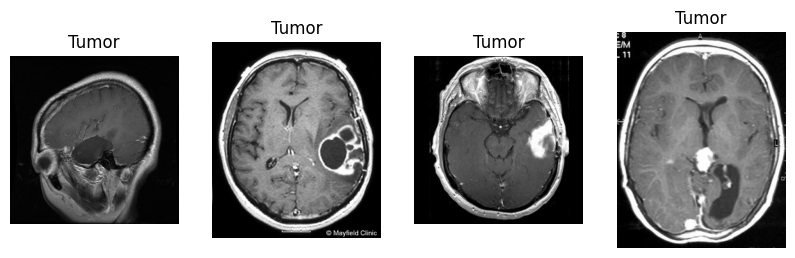

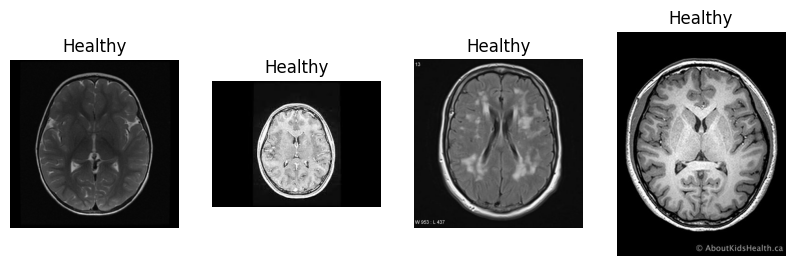

In [4]:
# Displaying Brain Tumor Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Brain Tumor/' + image_files_tumor[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Tumor')
plt.show()

# Displaying Healthy Brain Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Healthy/' + image_files_normal[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Healthy')
    
plt.show()

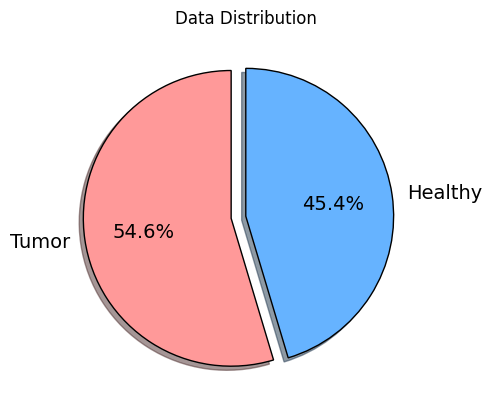

In [5]:
# visualizing the data distribution
data = {'Tumor': len(image_files_tumor), 'Healthy': len(image_files_normal)}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.pie(values, labels=names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True, textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black'})
ax.set_title('Data Distribution')
plt.show()

In [3]:
# Merging the data
data = []
data_gray = []
for file in image_files_tumor:
    # save the image and the label (1 for tumor)
    img = cv2.imread(url_tumor + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 1]) # 1 for tumor
    data_gray.append([grayscale_image, 1])
  
for file in image_files_normal:
    img = cv2.imread(url_healthy + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 0]) # 0 for normal
    data_gray.append([grayscale_image, 0])
    
# Creating a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df_gray = pd.DataFrame(data_gray, columns=['image', 'label'])
df_gray = df_gray.sample(frac=1).reset_index(drop=True)

In [10]:
# We have a meta data file that contains more information about the images

# Load the meta data
meta_data = pd.read_csv('metadata.csv', index_col=0)
meta_data.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


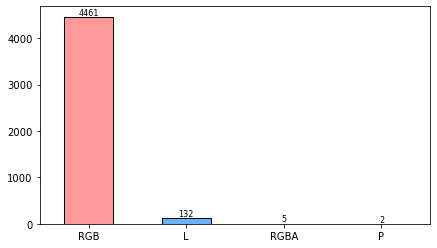

In [11]:
meta_data['mode'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff', '#ff55','#66b344'], rot=0, figsize=(7, 4), edgecolor='black')
for i, v in enumerate(meta_data['mode'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

#### Step 1: Train and Test the model with RGB images and flatting the data

In [4]:
# Split the data
X = np.array(df['image'].values.tolist())
y = df['label'].values

# Normalizing the data
X = X/ 255

In [5]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
# Flatten the image data
X_train_flat = np.array([x.flatten() for x in X_train])
X_val_flat = np.array([x.flatten() for x in X_val])

We will now try to run our models on the data without changing it

#### KNN Model

In [21]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train_flat, y_train)

# Predict the validation data
y_pred = knn.predict(X_val_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9429347826086957


#### SVM Model

In [7]:
# Create the SVM model
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_flat, y_train)

# Predict the validation data
y_pred = svm.predict(X_val_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9171195652173914


#### Random Forest Model


In [64]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Random Forest Validation Accuracy: 0.9633


We thought that maybe if we added PAC it would help with the results 

#### Principal Component Analysis (PCA)

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

##### Vizualizing the images after PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


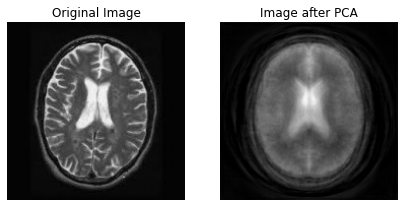

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(X_train_flat[8].reshape(175, 175, 3))
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(pca.inverse_transform(X_train_pca[8]).reshape(175, 175, 3))
ax[1].axis('off')
ax[1].set_title('Image after PCA')

plt.show()

In [25]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=8, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_pca, y_train)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.38step/s]

Random Forest Validation Accuracy with PCA: 0.9620


As we can see PAC indeed helped but not significantly.

#### Step 2: Train and test models with grayscale images and flatten

In [10]:
X_gray = np.array(df_gray['image'].values.tolist())
y_gray = df_gray['label'].values

# Normalizing the data
X_gray = X_gray/ 255

# Splitting the data into training and testing sets
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)

# Splitting the data into training and validation sets
X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_train_gray, y_train_gray, test_size=0.2, random_state=42, stratify=y_train_gray)

# Flatten the image data
X_train_flat_gray = np.array([x.flatten() for x in X_train_gray])
X_val_flat_gray = np.array([x.flatten() for x in X_val_gray])

Maybe if we try using gray scale we can improve results and also have quicker models because there is less data because there isn't a big neccesity for color to identify a tumor

#### XGBoost model

In [25]:
# Create the XGBoost model
model_gray = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model_gray.fit(X_train_flat_gray, y_train_gray)

# Make predictions
y_pred_gray = model_gray.predict(X_val_flat_gray)

# Evaluate the model
accuracy_gray = accuracy_score(y_val_gray, y_pred_gray)

print(f'Initial Accuracy with grayscale images: {accuracy_gray:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Accuracy with grayscale images: 0.9579


#### Random Forest model

In [32]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_flat_gray, y_train_gray)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat_gray)

# Evaluate the model
accuracy_rf = accuracy_score(y_val_gray, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01step/s]

Random Forest Validation Accuracy: 0.9470


In [11]:
def resize_images(images):
    # Initialize an array with the shape (num_samples, 224, 224, 1) for grayscale images
    resized_images = np.zeros((images.shape[0], 224, 224, 1))
    for i in range(images.shape[0]):
        # Ensure the image has shape (height, width, 1)
        if images[i].ndim == 2:  # If image is (height, width), add channel dimension
            image = np.expand_dims(images[i], axis=-1)
        elif images[i].ndim == 3 and images[i].shape[2] == 1:  # If image is already (height, width, 1)
            image = images[i]
        else:
            raise ValueError("Unexpected image shape: {}".format(images[i].shape))

        # Resize and expand dimensions to include the channel
        resized_image = tf.image.resize(image, (224, 224)).numpy()
        resized_images[i] = resized_image
    return resized_images

In [57]:
# Function to plot loss and accuracy
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plotting Loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plotting Accuracy
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.show()

# Assuming y_true and y_pred are defined
def plot_precision_recall(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

In [58]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
X_train_resized = resize_images(X_train_gray)
X_val_resized = resize_images(X_val_gray)
X_test_resized = resize_images(X_test_gray)

Lets try CNN ,maybe itll be better

#### CNN 

In [52]:
datagen = ImageDataGenerator(
    validation_split=0.2,  # Reserve 20% of images for validation
    horizontal_flip=True,
)

# Create generators for training and validation sets
train_generator = datagen.flow(
    X_train_resized, y_train_gray,
    batch_size=256,
    subset='training'
)

val_generator = datagen.flow(
    X_val_resized, y_val_gray,
    batch_size=256,
    subset='validation'
)

In [53]:
# Initialize a Sequential model
model = Sequential()

# Add Convolutional layers and pooling
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)))  # For grayscale
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output to feed into Dense layers
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary_crossentropy loss and specified metrics
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,073 (789.35 KB)

 Trainable params: 202,057 (789.29 KB)

 Non-trainable params: 16 (64.00 B)

In [54]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15


c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6083 - loss: 0.6695 - val_accuracy: 0.7687 - val_loss: 0.6569
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 714ms/step - accuracy: 0.7800 - loss: 0.4917 - val_accuracy: 0.8095 - val_loss: 0.6305
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step - accuracy: 0.8247 - loss: 0.4170 - val_accuracy: 0.8367 - val_loss: 0.6303
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 0.8939 - loss: 0.3385 - val_accuracy: 0.8503 - val_loss: 0.6198
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.9256 - loss: 0.2903 - val_accuracy: 0.8844 - val_loss: 0.6016
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 559ms/step - accuracy: 0.9425 - loss: 0.2514 - val_accuracy: 0.8912 - val_loss: 0.5817
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 529ms/step - accuracy: 0.9509 - loss: 0.2320 - val_accuracy: 0.9388 - val_loss: 0.5721
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 537ms/step - accuracy: 0.9664 - loss: 0.1985 - val_accuracy: 0.9116 - val_l

In [63]:
loss,accuracy = model.evaluate(X_test_resized,y_test_gray, verbose=1)
print(f"Loss: {loss} Accuracy: {accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9532 - loss: 0.4285
Loss: 0.4247811734676361 Accuracy: 0.960869550704956


As we can see its not so much better

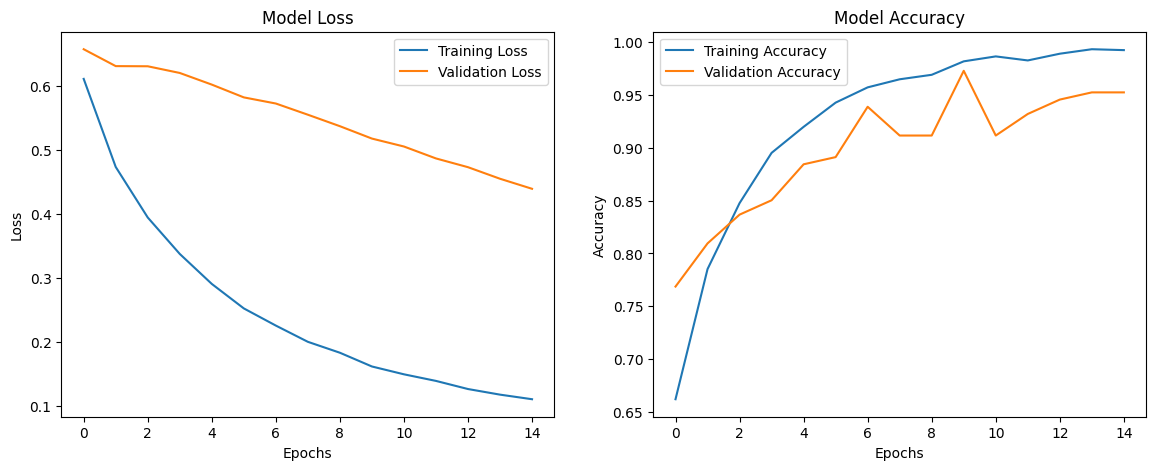

In [59]:
# save the model
model.save('brain_tumor_cnn_model.h5')

# Plot loss and accuracy
plot_loss_accuracy(history)

In [64]:
# Load the model
cnn_model = tf.keras.models.load_model('brain_tumor_cnn_model.h5')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Precision: 0.9814
Recall: 0.9792


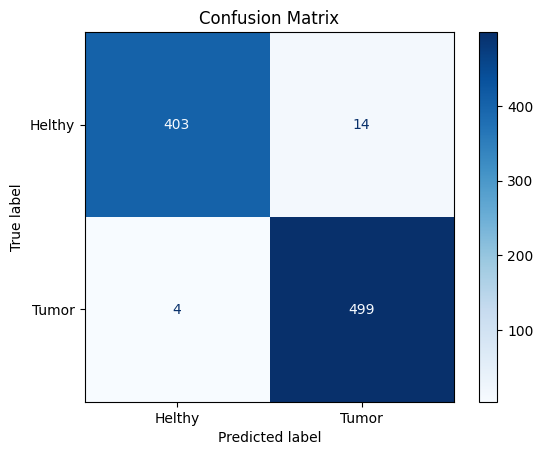

In [62]:
# Make predictions
y_pred = cnn_model.predict(X_test_resized)
y_pred = (y_pred > 0.5).astype(int)

# Plot metrics
plot_precision_recall(y_test_gray, y_pred)

# Assuming you have class names in a list called `class_names`
class_names = ['Helthy', 'Tumor']
plot_confusion_matrix(y_test_gray, y_pred, class_names)

צריך להריץ

Lets try to see what the model sees

#### LIME

  0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▏         | 10/700 [00:00<00:08, 81.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  3%|▎         | 20/700 [00:00<00:07, 86.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 30/700 [00:00<00:07, 90.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 43/700 [00:00<00:06, 103.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 54/700 [00:00<00:06, 102.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 66/700 [00:00<00:05, 107.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 78/700 [00:00<00:05, 111.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 90/700 [00:00<00:06, 90.96it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 101/700 [00:01<00:06, 95.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 116/700 [00:01<00:05, 109.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 128/700 [00:01<00:05, 109.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 20%|██        | 140/700 [00:01<00:07, 75.34it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 150/700 [00:01<00:07, 76.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 160/700 [00:01<00:07, 75.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 170/700 [00:01<00:07, 75.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 180/700 [00:02<00:06, 79.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 190/700 [00:02<00:06, 81.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 200/700 [00:02<00:05, 84.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 30%|███       | 210/700 [00:02<00:05, 86.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 220/700 [00:02<00:05, 89.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 230/700 [00:02<00:05, 91.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 240/700 [00:02<00:04, 93.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 250/700 [00:02<00:04, 93.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 260/700 [00:02<00:04, 92.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▊      | 270/700 [00:02<00:04, 91.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 280/700 [00:03<00:04, 89.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 290/700 [00:03<00:04, 89.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 300/700 [00:03<00:05, 74.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 310/700 [00:03<00:04, 78.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 320/700 [00:03<00:04, 79.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 330/700 [00:03<00:04, 77.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 340/700 [00:03<00:04, 79.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 350/700 [00:04<00:04, 83.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|█████▏    | 360/700 [00:04<00:04, 83.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 370/700 [00:04<00:03, 86.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 380/700 [00:04<00:03, 89.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 390/700 [00:04<00:03, 90.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 400/700 [00:04<00:03, 93.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 410/700 [00:04<00:03, 94.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 420/700 [00:04<00:02, 93.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 431/700 [00:04<00:02, 97.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 63%|██████▎   | 444/700 [00:04<00:02, 106.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▌   | 455/700 [00:05<00:02, 88.51it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▋   | 465/700 [00:05<00:02, 89.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 475/700 [00:05<00:02, 83.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 484/700 [00:05<00:02, 82.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 493/700 [00:05<00:02, 84.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 506/700 [00:05<00:02, 96.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▎  | 516/700 [00:05<00:02, 90.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 527/700 [00:05<00:01, 95.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 537/700 [00:06<00:01, 95.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 547/700 [00:06<00:01, 89.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|███████▉  | 557/700 [00:06<00:01, 89.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 567/700 [00:06<00:01, 89.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 577/700 [00:06<00:01, 88.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▎ | 586/700 [00:06<00:01, 85.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 595/700 [00:06<00:01, 82.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▋ | 604/700 [00:06<00:01, 70.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 612/700 [00:07<00:01, 72.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▊ | 620/700 [00:07<00:01, 72.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 630/700 [00:07<00:00, 77.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████▏| 640/700 [00:07<00:00, 82.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 93%|█████████▎| 650/700 [00:07<00:00, 87.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 660/700 [00:07<00:00, 88.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 670/700 [00:07<00:00, 88.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 680/700 [00:07<00:00, 88.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▊| 690/700 [00:07<00:00, 88.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|██████████| 700/700 [00:07<00:00, 87.65it/s]

Image 1 - Actual Label: Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image 1 - Predicted Label: Tumor


  0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▏         | 10/700 [00:00<00:07, 90.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 20/700 [00:00<00:07, 93.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|▍         | 30/700 [00:00<00:07, 92.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  6%|▌         | 40/700 [00:00<00:08, 74.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 50/700 [00:00<00:08, 77.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▊         | 60/700 [00:00<00:07, 80.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 70/700 [00:00<00:07, 80.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 81/700 [00:00<00:07, 87.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 90/700 [00:01<00:07, 85.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 101/700 [00:01<00:06, 92.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 111/700 [00:01<00:06, 91.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 121/700 [00:01<00:06, 93.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▊        | 131/700 [00:01<00:06, 94.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 141/700 [00:01<00:05, 95.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 151/700 [00:01<00:05, 93.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 161/700 [00:01<00:05, 94.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 171/700 [00:01<00:05, 95.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 181/700 [00:02<00:05, 93.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 191/700 [00:02<00:05, 92.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▊       | 201/700 [00:02<00:06, 78.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███       | 210/700 [00:02<00:06, 73.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███▏      | 220/700 [00:02<00:06, 72.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 230/700 [00:02<00:06, 74.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 240/700 [00:02<00:05, 78.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 250/700 [00:02<00:05, 82.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 260/700 [00:03<00:05, 86.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 39%|███▊      | 270/700 [00:03<00:04, 86.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 280/700 [00:03<00:04, 88.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 290/700 [00:03<00:04, 89.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 300/700 [00:03<00:04, 87.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 44%|████▍     | 310/700 [00:03<00:05, 73.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|████▌     | 320/700 [00:03<00:05, 75.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 330/700 [00:03<00:04, 78.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▊     | 340/700 [00:04<00:04, 77.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 350/700 [00:04<00:04, 82.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████▏    | 360/700 [00:04<00:03, 87.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 370/700 [00:04<00:03, 89.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 380/700 [00:04<00:03, 89.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 390/700 [00:04<00:03, 89.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 400/700 [00:04<00:03, 90.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 410/700 [00:04<00:03, 89.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 420/700 [00:04<00:03, 90.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 430/700 [00:05<00:02, 90.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 440/700 [00:05<00:02, 89.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 450/700 [00:05<00:02, 88.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 460/700 [00:05<00:02, 87.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 470/700 [00:05<00:03, 74.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▊   | 480/700 [00:05<00:02, 77.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 490/700 [00:05<00:02, 78.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 500/700 [00:05<00:02, 81.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 510/700 [00:06<00:02, 82.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 520/700 [00:06<00:02, 82.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 530/700 [00:06<00:02, 84.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 540/700 [00:06<00:02, 77.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 550/700 [00:06<00:01, 78.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 560/700 [00:06<00:01, 82.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████▏ | 570/700 [00:06<00:01, 87.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 580/700 [00:06<00:01, 86.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 590/700 [00:06<00:01, 86.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 600/700 [00:07<00:01, 85.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 610/700 [00:07<00:01, 88.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▊ | 620/700 [00:07<00:01, 71.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|█████████ | 630/700 [00:07<00:00, 75.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|█████████▏| 640/700 [00:07<00:00, 75.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 650/700 [00:07<00:00, 77.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 660/700 [00:07<00:00, 80.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 670/700 [00:07<00:00, 84.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 680/700 [00:08<00:00, 88.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▊| 690/700 [00:08<00:00, 86.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|██████████| 700/700 [00:08<00:00, 83.90it/s]

Image 2 - Actual Label: Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image 2 - Predicted Label: Tumor


  0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▏         | 10/700 [00:00<00:09, 74.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 20/700 [00:00<00:08, 78.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  4%|▍         | 30/700 [00:00<00:08, 81.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 40/700 [00:00<00:07, 82.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|▋         | 50/700 [00:00<00:09, 68.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▊         | 60/700 [00:00<00:09, 70.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|█         | 70/700 [00:00<00:08, 72.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 80/700 [00:01<00:08, 76.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 90/700 [00:01<00:08, 75.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 14%|█▍        | 100/700 [00:01<00:07, 79.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▌        | 110/700 [00:01<00:07, 80.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 120/700 [00:01<00:07, 77.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▊        | 130/700 [00:01<00:07, 79.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 140/700 [00:01<00:07, 78.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██▏       | 150/700 [00:01<00:06, 81.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|██▎       | 160/700 [00:02<00:06, 77.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 170/700 [00:02<00:07, 74.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██▌       | 180/700 [00:02<00:07, 65.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 190/700 [00:02<00:07, 70.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|██▊       | 200/700 [00:02<00:07, 68.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 210/700 [00:02<00:06, 70.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███▏      | 220/700 [00:02<00:06, 74.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 230/700 [00:03<00:05, 78.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 240/700 [00:03<00:05, 81.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 250/700 [00:03<00:05, 84.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|███▋      | 260/700 [00:03<00:05, 83.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 270/700 [00:03<00:05, 83.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|████      | 280/700 [00:03<00:05, 79.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 290/700 [00:03<00:05, 80.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 300/700 [00:03<00:05, 79.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 310/700 [00:04<00:04, 80.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 46%|████▌     | 320/700 [00:04<00:05, 74.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 330/700 [00:04<00:04, 76.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 49%|████▊     | 340/700 [00:04<00:05, 65.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 350/700 [00:04<00:05, 69.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████▏    | 360/700 [00:04<00:04, 73.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 370/700 [00:04<00:04, 79.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 380/700 [00:04<00:03, 80.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 390/700 [00:05<00:03, 82.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 57%|█████▋    | 400/700 [00:05<00:03, 75.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▊    | 410/700 [00:05<00:03, 76.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 420/700 [00:05<00:03, 76.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 430/700 [00:05<00:03, 71.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 63%|██████▎   | 440/700 [00:05<00:03, 71.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▍   | 450/700 [00:05<00:03, 73.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 460/700 [00:06<00:03, 78.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 470/700 [00:06<00:02, 82.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▊   | 480/700 [00:06<00:02, 83.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 70%|███████   | 490/700 [00:06<00:02, 71.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 71%|███████▏  | 500/700 [00:06<00:02, 68.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 510/700 [00:06<00:02, 71.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 520/700 [00:06<00:02, 74.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 530/700 [00:06<00:02, 78.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 77%|███████▋  | 540/700 [00:07<00:02, 77.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 79%|███████▊  | 550/700 [00:07<00:01, 76.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 560/700 [00:07<00:01, 75.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 570/700 [00:07<00:01, 75.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 580/700 [00:07<00:01, 75.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 590/700 [00:07<00:01, 77.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 600/700 [00:07<00:01, 78.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 610/700 [00:07<00:01, 79.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 620/700 [00:08<00:00, 81.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 630/700 [00:08<00:00, 83.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 640/700 [00:08<00:00, 68.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 650/700 [00:08<00:00, 74.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 660/700 [00:08<00:00, 77.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▌| 670/700 [00:08<00:00, 73.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 680/700 [00:08<00:00, 73.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 690/700 [00:09<00:00, 73.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 700/700 [00:09<00:00, 76.11it/s]

Image 3 - Actual Label: Tumor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 3 - Predicted Label: Tumor


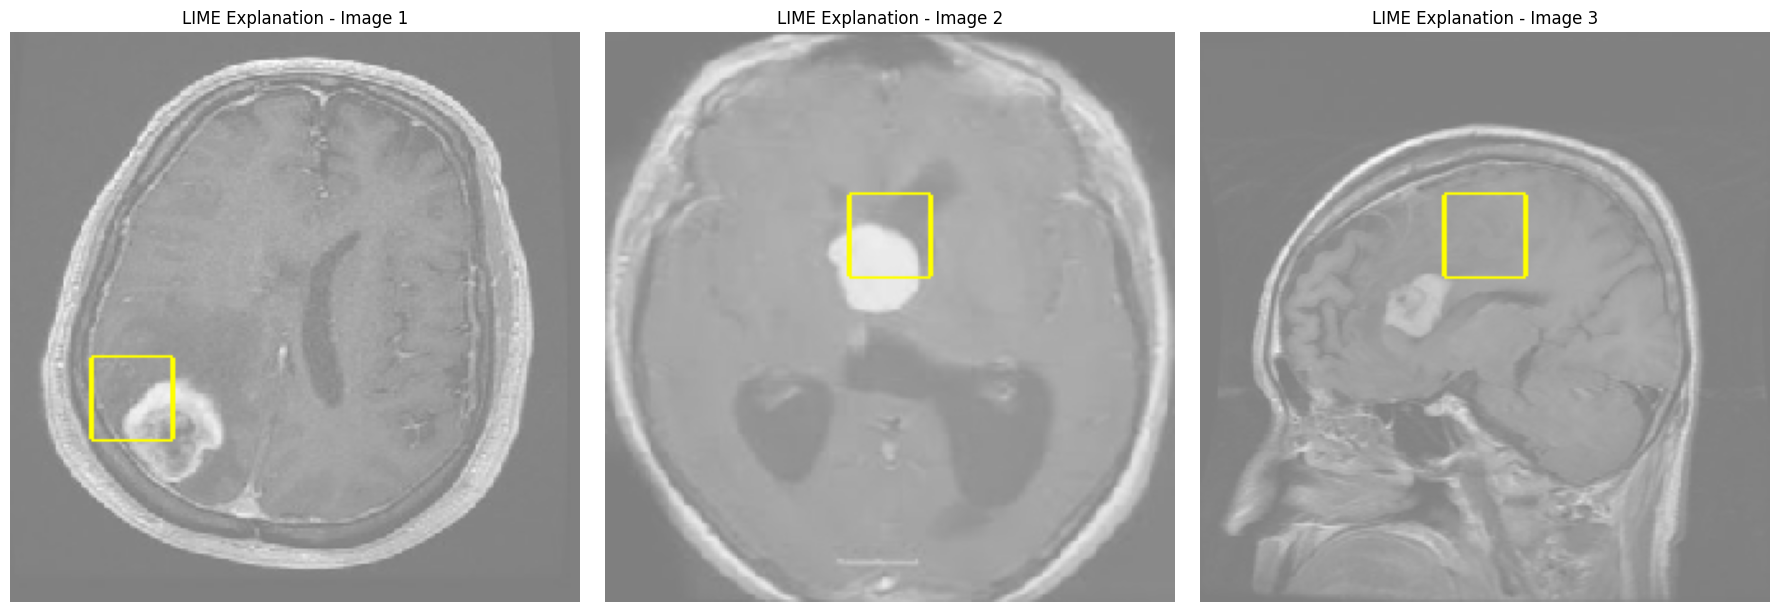

In [164]:

# model = tf.keras.models.load_model('brain_tumor_cnn_model.h5')
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (971).jpg'

# Define the image paths
image_paths = [
    'Brain Tumor Data Set/Brain Tumor/Cancer (971).jpg',
    'Brain Tumor Data Set/Brain Tumor/Cancer (40).tif',
    'Brain Tumor Data Set/Brain Tumor/Cancer (252).jpg'
]

# Function to preprocess the image for the model
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Prediction function for LIME
def predict_fn(images):
    images = np.array(images)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=0)
    preds = model.predict(images)
    return preds

# Custom segmentation function for grayscale images
def segmentation_fn(image):
    return slic(image, n_segments=50, compactness=10)

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer(random_state=42)

# Function to convert the grayscale image to RGB for visualization
def convert_to_rgb(image):
    if image.ndim == 2 or image.shape[-1] == 1:
        image = np.dstack([image, image, image])
    return image


# Create a figure to plot the images in the same row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through the image paths and generate LIME explanations
for i, image_path in enumerate(image_paths):
    # Preprocess the sample image
    sample_image = preprocess_image(image_path)

    # Explain the prediction
    explanation = explainer.explain_instance(
        sample_image[0].astype('double'), 
        predict_fn, 
        top_labels=1, 
        hide_color=0, 
        num_samples=700,
        segmentation_fn=segmentation_fn
    )

    # Get the explanation for the top class with only the most important features
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], 
        positive_only=True, 
        num_features=1,  # Show only the top 1 feature
        hide_rest=False
    )

    # Print the actual label and the predicted label
    print(f'Image {i+1} - Actual Label: Tumor')
    predicted_probability = model.predict(sample_image)[0][0]
    predicted_label = 'Tumor' if predicted_probability > 0.5 else 'Healthy'
    print(f'Image {i+1} - Predicted Label: {predicted_label}')

    # Convert the grayscale image to RGB for mark_boundaries
    temp_rgb = convert_to_rgb(temp / 2 + 0.5)
    
    # Plot the image in the corresponding subplot
    axes[i].imshow(mark_boundaries(temp_rgb, mask))
    axes[i].set_title(f'LIME Explanation - Image {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Although the model predicts the images correctly, not all the LIME explanations are accurate.
This is because LIME is an approximation method and may not always provide the most accurate explanation.

#### Canny edge detection

Maybe if we can use canny to find lines we can focus on areas that are more likely to be tumors

In [8]:
def apply_canny_edge_detection(image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    edges_image = apply_canny_edge_detection(grayscale_image)
    edges_image = edges_image.flatten()  # Flatten the image for the Random Forest
    return edges_image

def load_and_preprocess_data():
    data = []
    labels = []

    for file in image_files_tumor:
        img = cv2.imread(url_tumor + file)
        edges_image = preprocess_image(img)
        data.append(edges_image)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        img = cv2.imread(url_healthy + file)
        edges_image = preprocess_image(img)
        data.append(edges_image)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [9]:
data, labels = load_and_preprocess_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,stratify=labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [13]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (2385).jpg'
sample_image = cv2.imread(sample_image_path)
processed_image = preprocess_image(sample_image)
processed_image = processed_image.reshape(1, -1)  # Reshape for prediction

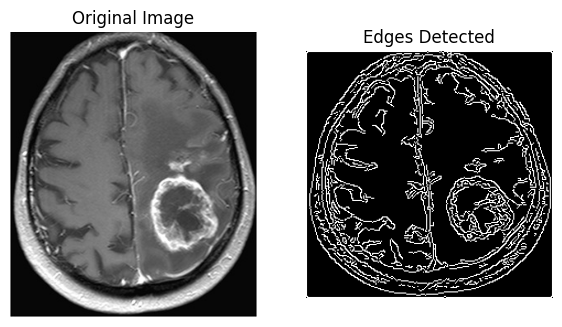

In [15]:
# show the image with the edges detected and the original image

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image')

edges_image = processed_image.reshape(224, 224)
ax[1].imshow(edges_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Edges Detected')

plt.show()

#### SVM model

In [8]:
# Create the SVM model
svm_model = SVC(kernel='linear', C=1)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = svm_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9605978260869565


#### KNN model

In [28]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# Predict the validation data
y_pred = knn.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.6073369565217391


as we can see it did not help

lets try histogram equalization

#### Histogram Equalization

In [3]:
def apply_histogram_equalization(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    equalized_image = apply_histogram_equalization(grayscale_image)
    equalized_image = equalized_image.flatten()
    return equalized_image

def load_and_preprocess_data():
    data = []
    labels = []

    for file in image_files_tumor:
        img = cv2.imread(url_tumor + file)
        equalized_image = preprocess_image(img)
        data.append(equalized_image)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        img = cv2.imread(url_healthy + file)
        equalized_image = preprocess_image(img)
        data.append(equalized_image)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [4]:
data, labels = load_and_preprocess_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (2385).jpg'
sample_image = cv2.imread(sample_image_path)
processed_image = preprocess_image(sample_image)
processed_image = processed_image.reshape(1, -1)  # Reshape for prediction

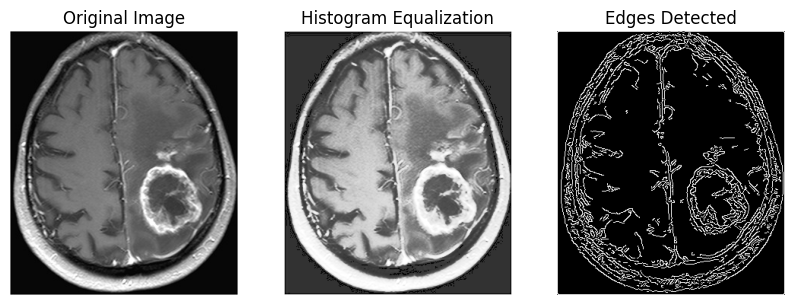

In [25]:
# plot the image with the histogram equalization, edges detected and the original image

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image')

equalized_image = apply_histogram_equalization(cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY))
ax[1].imshow(equalized_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Histogram Equalization')

edges_image = apply_canny_edge_detection(cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY))
ax[2].imshow(edges_image, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Edges Detected')

plt.show()


#### Random Forest Model

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9633


#### Xgboost Model

In [6]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.9660


it's better than regular but not by much

lets try PAC

#### PCA on the histogram equalized images data

In [5]:
# Apply PCA to the data
pca = PCA(n_components=60)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [30]:
# XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train_pca, y_train)

# Predict and evaluate the model on the validation set
y_pred_val = model.predict(X_val_pca)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy_val:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9728


Wow we got to 97% not bad but can we do better?

### VGG16 for features extraction

lets try feature extraction

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [13]:
def extract_vgg_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

In [1]:
def load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy):
    data = []
    labels = []

    for file in image_files_tumor:
        features = extract_vgg_features(url_tumor + file)
        data.append(features)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        features = extract_vgg_features(url_healthy + file)
        data.append(features)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

```python 

data, labels = load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy)

# save the data and labels
np.save('data.npy', data)
np.save('labels.npy', labels)
```

In [30]:
# load the data and labels
data = np.load('data.npy')
labels = np.load('labels.npy')

# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [7]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (492).jpg'

#### Random Forest model

In [31]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=5, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train, y_train)
    pbar.update(100)
pbar.close()

y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# test the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Training Progress: 100%|██████████| 100/100 [01:42<00:00,  1.03s/step]


Validation Accuracy: 0.9728
Test Accuracy: 0.9674


### Xgboost model


In [32]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# test the model
y_pred = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9891
Test Accuracy: 0.9717


#### SVM model


In [37]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# test the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


Validation Accuracy: 0.9891
Test Accuracy: 0.9848


wow 98.4% thats amazing!

#### KNN

In [38]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# test the model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9728
Test Accuracy: 0.9652


#### Logistic Regression model

In [39]:
logreg_model = LogisticRegression(max_iter=10000)
logreg_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_val = logreg_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy_val:.4f}')

# test the model
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9891
Test Accuracy: 0.9793


### ResNet50 for features extraction

In [10]:
def extract_features(image_path,model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Load pre-trained model
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [20]:
def load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy):
    data = []
    labels = []

    for file in image_files_tumor:
        features = extract_features(url_tumor + file, resnet_model)
        data.append(features)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        features = extract_features(url_healthy + file, resnet_model)
        data.append(features)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

```python 
data, labels = load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy)

# save the data and labels
np.save('resnet_data.npy', data)
np.save('resnet_labels.npy', labels)
``` 

In [4]:
# load the data and labels
data = np.load('resnet_data.npy')
labels = np.load('resnet_labels.npy')

# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

#### SVM model


In [5]:
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9905


In [6]:
# test the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9826


#### KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')


Validation Accuracy: 0.9891


In [26]:
# test the model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9783


#### Logistic Regression model

In [28]:
logreg_model = LogisticRegression(max_iter=10000)
logreg_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_val = logreg_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy_val:.4f}')

Validation Accuracy: 0.9891


In [29]:
# test the model
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9783


As we can see VGG16 was better

### Model Performance Summary

| Image Processing Technique       | Model               | Validation Accuracy | Test Accuracy |
|----------------------------------|---------------------|---------------------|---------------|
| RGB + Flatten                    | KNN                 | 0.942               | -             |
| RGB + Flatten                    | Random Forest       | 0.963               | -             |
| RGB + Flatten                    | SVM                 | 0.917               | -             |
| RGB + Flatten + PCA              | Random Forest       | 0.962               | -             |
| Gray Scale + Flatten             | Random Forest       | 0.947               | -             |
| Gray Scale + Flatten             | XGBoost             | 0.957               | -             |
| Gray Scale + Flatten             | CNN                 | 0.953               | 0.960         |
| Canny Edge Detection             | KNN                 | 0.960               | -             |
| Canny Edge Detection             | SVM                 | 0.600               | -             |
| Histogram Equalization           | Random Forest       | 0.963               | -             |
| Histogram Equalization           | XGBoost             | 0.966               | -             |
| Histogram Equalization + PCA     | XGBoost             | 0.972               | -             |
| VGG16 for Feature Extraction     | Random Forest       | 0.972               | 0.967         |
| VGG16 for Feature Extraction     | XGBoost             | 0.989               | 0.971         |
| VGG16 for Feature Extraction     | SVM                 | 0.989               | 0.984         |
| VGG16 for Feature Extraction     | KNN                 | 0.972               | 0.965         |
| VGG16 for Feature Extraction     | Logistic Regression | 0.989               | 0.979         |
| ResNet50 for Feature Extraction  | SVM                 | 0.990               | 0.982         |
| ResNet50 for Feature Extraction  | KNN                 | 0.989               | 0.978         |
| ResNet50 for Feature Extraction  | Logistic Regression | 0.989               | 0.979         |


#### Summary

1. **Preprocessing Techniques**:
   - Various image preprocessing techniques were employed, including RGB conversion, grayscale conversion, edge detection, histogram equalization, and feature extraction using VGG16 and ResNet50.

2. **Model Performance**:
   - The highest validation accuracy was achieved by using VGG16 and ResNet50 for feature extraction followed by SVM, XGBoost, and Logistic Regression models, all reaching up to 0.989-0.990.
   - The test accuracy was also high for these models, with SVM using VGG16 achieving the highest test accuracy of 0.984.

3. **Feature Extraction**:
   - Feature extraction using pre-trained models (VGG16 and ResNet50) significantly improved model performance compared to basic image preprocessing techniques like flattening and PCA.

4. **Best Performing Models**:
   - SVM with VGG16 and ResNet50 feature extraction provided the best validation accuracy.
   - Logistic Regression and XGBoost also performed exceptionally well with feature extraction methods.

5. **Conclusion**:
   - Advanced feature extraction techniques using pre-trained models such as VGG16 and ResNet50 combined with powerful classifiers like SVM, XGBoost, and Logistic Regression offer the best performance for brain tumor classification tasks.